# Heisenberg chain
*Usage estimate: 2 minutes on IBM Cusco (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

In this tutorial, we will show how to build, deploy, and run a `Qiskit Pattern` for simulating a Heisenberg chain and estimating its ground state energy. For more information on `Qiskit Patterns` and how `Qiskit Serverless` can be used to deploy them to the cloud for managed execution, visit our [docs page on the IBM Quantum Platform](https://docs.quantum.ibm.com/run/quantum-serverless).

## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.2 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.28 or later (`pip install qiskit-ibm-runtime`) 0.22 or later

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from typing import Sequence


from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives.base import BaseEstimatorV2
from qiskit.circuit.library import XGate
from qiskit.circuit.library import efficient_su2
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, Estimator

from qiskit_ibm_catalog import QiskitServerless, QiskitFunction


def visualize_results(results):
    plt.plot(results["cost_history"], lw=2)
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.show()


def build_callback(
    ansatz: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    estimator: BaseEstimatorV2,
    callback_dict: dict,
):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        current_cost = (
            estimator.run([(ansatz, hamiltonian, [current_vector])])
            .result()[0]
            .data.evs[0]
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(
                callback_dict["iters"], current_cost
            ),
            end="\r",
            flush=True,
        )

    return callback

## Step 1: Map classical inputs to a quantum problem

*   Input: Number of spins
*   Output: Ansatz and Hamiltonian modeling the Heisenberg chain

Construct an ansatz and Hamiltonian which model a 10-spin Heisenberg chain. First, we import some generic packages and create a couple of helper functions.

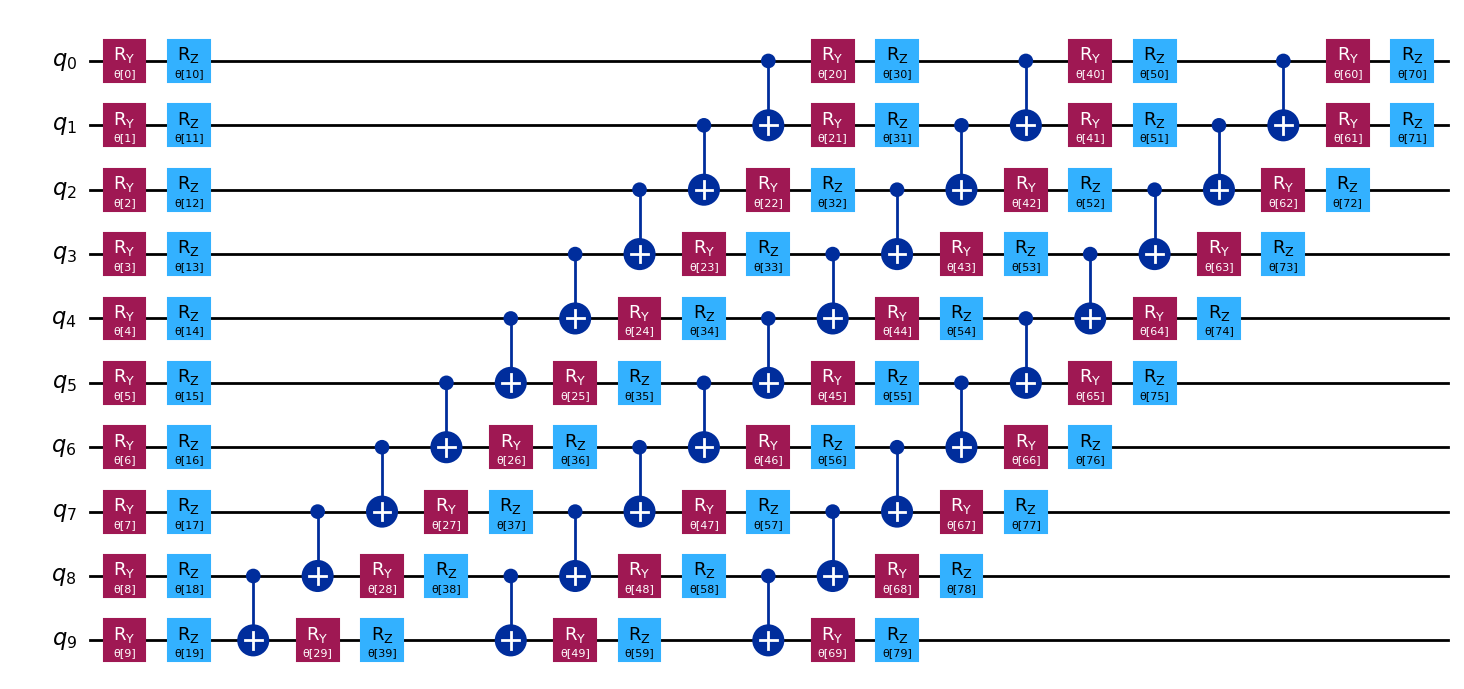

In [2]:
num_spins = 10
ansatz = efficient_su2(num_qubits=num_spins, reps=3)

# Remember to insert your token in the QiskitRuntimeService constructor
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, min_num_qubits=num_spins, simulator=False
)

coupling = backend.target.build_coupling_map()
reduced_coupling = coupling.reduce(list(range(num_spins)))

edge_list = reduced_coupling.graph.edge_list()
ham_list = []

for edge in edge_list:
    ham_list.append(("ZZ", edge, 0.5))
    ham_list.append(("YY", edge, 0.5))
    ham_list.append(("XX", edge, 0.5))

for qubit in reduced_coupling.physical_qubits:
    ham_list.append(("Z", [qubit], np.random.random() * 2 - 1))

hamiltonian = SparsePauliOp.from_sparse_list(ham_list, num_qubits=num_spins)

ansatz.draw("mpl", style="iqp")

## Step 2: Optimize problem for quantum hardware execution

*   Input: Abstract circuit, observable
*   Output: Target circuit and observable, optimized for the selected QPU

Use the `generate_preset_pass_manager` function from Qiskit to automatically generate an optimization routine for our circuit with respect to the selected QPU. We choose `optimization_level=3`, which provides the highest level of optimization of the preset pass managers. We also include `ALAPScheduleAnalysis` and `PadDynamicalDecoupling` scheduling passes to suppress decoherence errors.

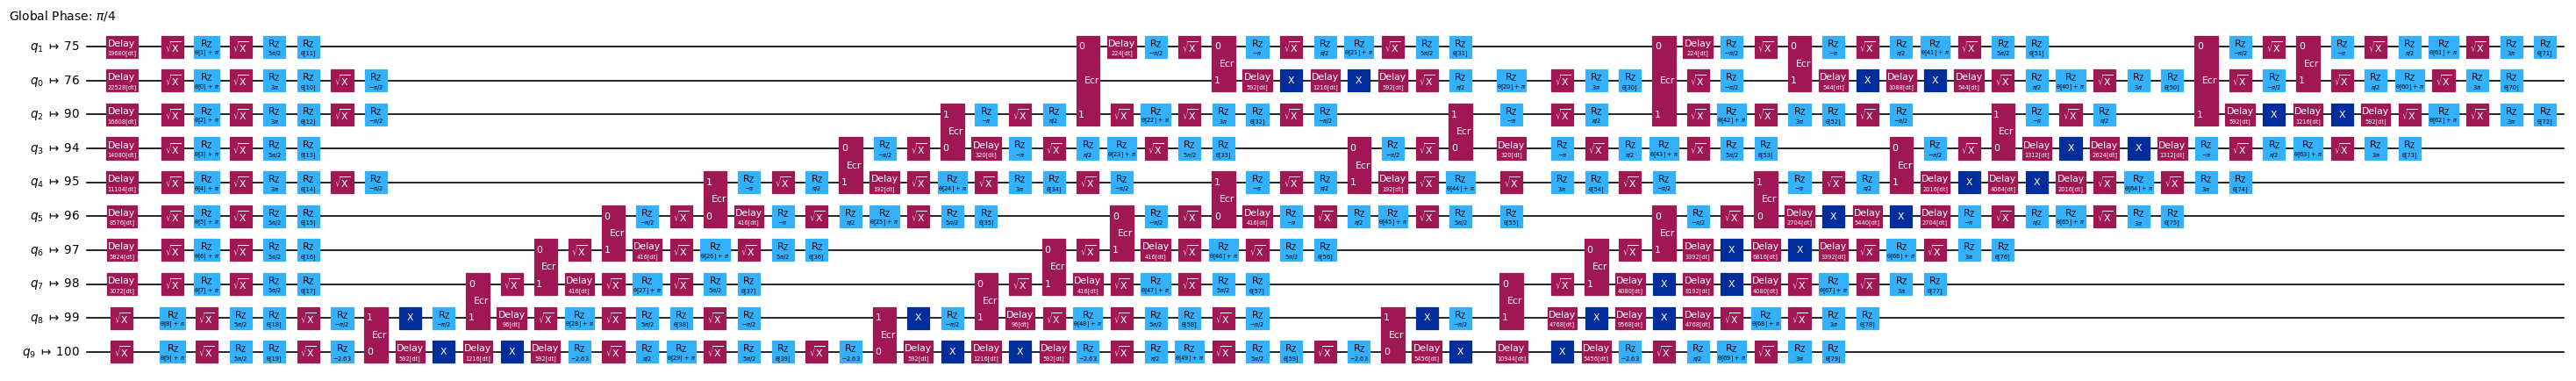

In [4]:
target = backend.target
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(durations=target.durations()),
        PadDynamicalDecoupling(
            durations=target.durations(),
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)
ansatz_ibm = pm.run(ansatz)
observable_ibm = hamiltonian.apply_layout(ansatz_ibm.layout)
ansatz_ibm.draw("mpl", scale=0.6, style="iqp", fold=-1, idle_wires=False)

## Step 3: Execute using Qiskit primitives

*   Input: Target circuit and observable
*   Output: Results of optimization

Minimize the estimated ground state energy of the system by optimizing the circuit parameters. Use the `Estimator` primitive from Qiskit Runtime to evaluate the cost function during optimization.

Since we optimized the circuit for the backend in Step 2, we can avoid doing transpilation on the Runtime server by setting `skip_transpilation=True` and passing the optimized circuit. For this demo, we will run on a QPU using `qiskit-ibm-runtime` primitives. To run with `qiskit` statevector-based primitives, replace the block of code using Qiskit IBM Runtime primitives with the commented block.

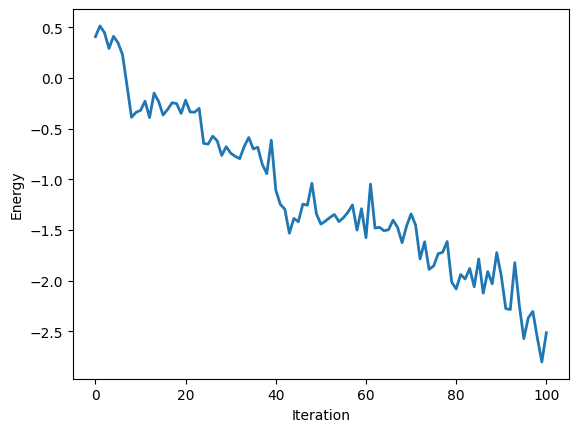

In [6]:
# SciPy minimizer routine
def cost_func(
    params: Sequence,
    ansatz: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    estimator: BaseEstimatorV2,
) -> float:
    """Ground state energy evaluation."""
    return (
        estimator.run([(ansatz, hamiltonian, [params])])
        .result()[0]
        .data.evs[0]
    )


num_params = ansatz_ibm.num_parameters
params = 2 * np.pi * np.random.random(num_params)

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

# Evaluate the problem using a QPU via Qiskit IBM Runtime
with Session(backend=backend) as session:
    estimator = Estimator()
    callback = build_callback(
        ansatz_ibm, observable_ibm, estimator, callback_dict
    )
    res = minimize(
        cost_func,
        x0=params,
        args=(ansatz_ibm, observable_ibm, estimator),
        callback=callback,
        method="cobyla",
        options={"maxiter": 100},
    )

visualize_results(callback_dict)

## Step 4: Post-process and return result in desired classical format

*   Input: Ground state energy estimates during optimization
*   Output: Estimated ground state energy

In [5]:
print(f'Estimated ground state energy: {res["fun"]}')

Estimated ground state energy: -2.594437119769288


## Deploy the Qiskit Pattern to the cloud

To do this, move the source code above to a file, `./source/heisenberg.py`, wrap the code in a script which takes inputs and returns the final solution, and finally upload it to a remote cluster using the `QiskitFunction` class from `qiskit-ibm-catalog`. For guidance on specifying external dependencies, passing input arguments, and more, check out the [Qiskit Serverless guides](https://quantum.cloud.ibm.com/docs/en/guides/serverless).

The input to the Pattern is the number of spins in the chain. The output is an estimation of the ground state energy of the system.

In [ ]:
# Authenticate to the remote cluster and submit the pattern for remote execution
serverless = QiskitServerless()
heisenberg_function = QiskitFunction(
    title="ibm_heisenberg",
    entrypoint="heisenberg.py",
    working_dir="./source/",
)
serverless.upload(heisenberg_function)

### Run the Qiskit Pattern as a managed service

Once we have uploaded the pattern to the cloud, we can easily run it using the `QiskitServerless` client.

In [ ]:
# Run the pattern on the remote cluster

ibm_heisenberg = serverless.load("ibm_heisenberg")
job = serverless.run(ibm_heisenberg)
solution = job.result()

print(solution)
print(job.logs())

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_bfuBwfNeeFBxnim)

© IBM Corp. 2023, 2024